In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
%matplotlib inline  

In [2]:
X = pd.read_csv('data.dat', sep="   ", header=None).to_numpy().T
lab = pd.read_csv('label.dat', sep="   ", header=None).to_numpy()

/home/jfftilton/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  """Entry point for launching an IPython kernel.
/home/jfftilton/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  


In [14]:
def initialization(X, K):
    m,n=X.shape
    pis = np.random.dirichlet(np.ones(K),size=1).reshape(K)
    mus = np.array([np.random.normal(0, 1, n),np.random.normal(0, 1, n)])
    sigmas = np.array([np.identity(n)]*K)
    return pis, mus, sigmas

def low_rank(x, mu, sigma, r):
    # eigenvalue decomposition
    n = len(x)
    e_val, e_vec = np.linalg.eigh(sigma)
    #order eigenvalue/vectors in descending order
    idx = np.argsort(e_val)[::-1]
    e_val = e_val[idx]
    e_vec = e_vec[:,idx]
    
    #threshold
    e_val = e_val[:r]
    e_vec = e_vec[:,:r]
    
    # Low rank approximation of values 
    sigma_approx = np.dot(np.dot(e_vec,np.diag(e_val**-1)),e_vec.T)
    mu_approx = np.dot(e_vec.T,mu)
    
    return mu_approx, sigma_approx, e_val, e_vec

def get_likelihood(x, mu, sigma, r):
    mu_approx, sigma_approx, e_val, e_vec = low_rank(x, mu, sigma, r=r)
    x_approx = np.dot(e_vec.T,x)
    e_val_diag = np.diag(e_val**-1)
    x_minus_mu = x_approx - mu_approx
    n = np.exp(-.5*np.dot(np.dot(x_minus_mu.T, e_val_diag),x_minus_mu))
    d = np.sqrt(np.prod(e_val))
    likelihood = n / d
    log_likelihood = np.log(n) + np.log(d)
    return likelihood, log_likelihood

def e_step(X, mus, sigmas, pis, r):
    assert len(mus) == len(sigmas) == len(pis)
    K = len(mus)
    m,n = X.shape
    taus = np.zeros(shape=(m,K))
    sum_log_likelihoods = 0
    k=0
    for mu, sigma, pi in zip(mus, sigmas, pis):
        lls = np.apply_along_axis(get_likelihood, 1, X, mu, sigma, r)
        likelihood = lls[:,0]
        sum_likelihoods = np.sum(likelihood)
        log_likelihoods = lls[:,1]
        sum_log_likelihoods += np.sum(log_likelihoods)
        tau = (likelihood/sum_likelihoods)
        taus[:,k] = tau
        k+=1
    return taus,sum_log_likelihoods

def get_sigmas(X,expectations,mus):
    n,m=X.shape
    K = expectations.shape[1]
    sigmas = np.zeros((K, m, m))
    for k in range(K):
        tau = expectations[:,k]
        mu = mus[k,:]
        numerator = np.zeros(shape=(m,m))
        for i in range(n):
            x_i=X[i,:]
            tau_i = tau[i]
            x_i_minus_mu = (x_i - mu).reshape(m,1)
            numerator += tau_i*np.dot(x_i_minus_mu,x_i_minus_mu.T)
        sigmas[k] = numerator / np.sum(tau)
            
    return sigmas

def get_mus(X,expectations):
    n,m=X.shape
    K = expectations.shape[1]
    mus = np.zeros(shape=(K,m))
    for k in range(K):
        tau = expectations[:,k]
        numerator = np.zeros(shape=(m))
        for i in range(n):
            x_i=X[i,:]
            tau_i = tau[i]
            numerator += tau_i * x_i
        mu = numerator / np.sum(tau)
        mus[k] = mu
    return mus

def m_step(expectations, X):
    n, m = X.shape
    _,k = expectations.shape
    
    pis = expectations.sum(axis=0) / n

    mus = get_mus(X,expectations)

    sigmas = get_sigmas(X,expectations,mus)
    return pis, mus, sigmas 


def em(X,K=2, low_rank_thresh=5, log_likelihood_thresh=.1, max_iter=100):
    ll = np.inf
    pis, mus, sigmas = initialization(X, K)
    lls = []
    for i in range(max_iter):
        expectations, log_likelihood = e_step(X, mus, sigmas, pis, r =low_rank_thresh)
        pis, mus, sigmas=m_step(expectations, X)
        lls.append(log_likelihood)
        print("Log likelihood step {}: {}".format(str(i+1), str(np.round(log_likelihood))))
        if np.abs(log_likelihood - ll) <= log_likelihood_thresh:
            break
        ll = log_likelihood 
    return lls, pis, mus, sigmas


In [15]:
K=2
pis, mus, sigmas = initialization(X, K)

In [16]:
lls, pis, mus, sigmas = em(X,K=2, low_rank_thresh=50, log_likelihood_thresh=.1, max_iter=100)

Log likelihood step 1: -109675.0
Log likelihood step 2: -275808.0


/home/jfftilton/.local/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarning: divide by zero encountered in log


Log likelihood step 3: -inf


/home/jfftilton/.local/lib/python3.6/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in double_scalars
/home/jfftilton/.local/lib/python3.6/site-packages/ipykernel_launcher.py:34: RuntimeWarning: divide by zero encountered in double_scalars


KeyboardInterrupt: 

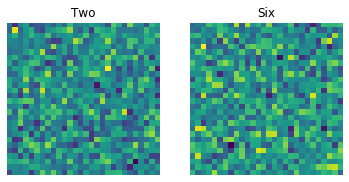

In [13]:
t1 = np.flip(np.rot90(mus[0,:].reshape(28,28), -1), 1)
t2 = np.flip(np.rot90(mus[1,:].reshape(28,28), -1), 1)
plt.subplot(1, 2, 1)
plt.title("Two")
plt.imshow(t1)
plt.axis("off")

plt.subplot(1, 2, 2)
plt.title("Six")
plt.imshow(t2)
plt.axis("off")
plt.show()

In [7]:
w,v = np.linalg.eigh(sigmas[0,:,:])

In [21]:
# PCA using SVD
U, S, V = np.linalg.svd(sigmas[0,:,:], 
      full_matrices=False,
      compute_uv=True)

[np.dot(np.dot(U,np.diag(S)), U.T) == sigmas[0,:,:]]

[array([[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        ...,
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]])]

In [22]:
S

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1.